# RespiraHub — Trial 5: HeAR Health Acoustic Backbone

**Why HeAR:**
- Wav2Vec2 (speech model) ceiling: 0.733 across 4 trials
- HeAR: pre-trained on 313M health audio clips (coughs, breaths, lung sounds)
- Proven SOTA on 33 health acoustic tasks including TB cough inference
- Superior device generalizability (important for puskesmas deployment)
- Data efficient: can match performance with 6.25% of training data

**Approach:** Extract frozen HeAR embeddings (512-dim) → train lightweight classifier

**Input:** 2 seconds @ 16kHz (HeAR native, vs 3s for Wav2Vec2)

**Target:** Beat Trial 1 Wav2Vec2 (0.733) and DREAM Challenge winner (0.743)

---
## Cell 1: Setup + Install HeAR

In [1]:
# First time only: clone HeAR repo for audio preprocessing utils
import os
if not os.path.exists('hear'):
    !git clone https://github.com/Google-Health/hear.git
    !pip install --upgrade --quiet transformers==4.50.3

import json, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel
from tqdm import tqdm
import importlib
import warnings
warnings.filterwarnings('ignore')

# HeAR preprocessing
audio_utils = importlib.import_module('hear.python.data_processing.audio_utils')
preprocess_audio = audio_utils.preprocess_audio

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('Using Apple Silicon MPS')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using CUDA')
else:
    DEVICE = torch.device('cpu')
    print('Using CPU')

print(f'PyTorch {torch.__version__}, Device: {DEVICE}')

Cloning into 'hear'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 216 (delta 72), reused 47 (delta 47), pack-reused 129 (from 1)
Receiving objects: 100% (216/216), 62.06 MiB | 2.00 MiB/s, done.
Resolving deltas: 100% (128/128), done.


/Users/aida/code/development/tb-datasets/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Apple Silicon MPS
PyTorch 2.10.0, Device: mps


---
## Cell 2: Load HeAR Model

In [ ]:
import os
from huggingface_hub import login

hf_token = os.environ.get('HF_TOKEN')
if not hf_token:
    raise ValueError("Set env variable: export HF_TOKEN=your_token_here")
login(token=hf_token)

print('Loading HeAR model...')
hear_model = AutoModel.from_pretrained('google/hear-pytorch', trust_remote_code=True)
hear_model = hear_model.to(DEVICE)
hear_model.eval()

# Freeze all
for param in hear_model.parameters():
    param.requires_grad = False

n_params = sum(p.numel() for p in hear_model.parameters())
print(f'HeAR loaded: {n_params/1e6:.1f}M params (all frozen)')

# Test: random 2s audio → embedding
test_audio = torch.rand((2, 32000), dtype=torch.float32)
test_spec = preprocess_audio(test_audio)
with torch.no_grad():
    test_out = hear_model.forward(test_spec.to(DEVICE), return_dict=True, output_hidden_states=True)
    test_emb = test_out.last_hidden_state[:, 0, :]  # CLS token
print(f'Input: {test_audio.shape} → Spectrogram: {test_spec.shape} → Embedding: {test_emb.shape}')
print(f'Embedding dim: {test_emb.shape[-1]}')

---
## Cell 3: Load Metadata + Build 2s Segments

HeAR uses 2s native. Strategy: Trial 1 style (concatenate all + split) but 2s windows.

In [8]:
AUDIO_DIR = 'data/solicited/'
CLINICAL_PATH = 'data/metadata/CODA_TB_Clinical_Meta_Info.csv'
ADDITIONAL_PATH = 'data/metadata/CODA_TB_additional_variables_train.csv'
SOLICITED_PATH = 'data/metadata/CODA_TB_Solicited_Meta_Info.csv'

clinical = pd.read_csv(CLINICAL_PATH)
additional = pd.read_csv(ADDITIONAL_PATH)
solicited = pd.read_csv(SOLICITED_PATH)

meta = clinical.merge(additional, on='participant', how='left')
meta['label'] = meta['tb_status'].astype(int)

df = solicited.merge(meta, on='participant', how='left')
df['filepath'] = df['filename'].apply(lambda f: os.path.join(AUDIO_DIR, f))
df['file_exists'] = df['filepath'].apply(os.path.exists)
df = df[df['file_exists']].reset_index(drop=True)

print(f'Participants: {meta["label"].count()}, TB+: {meta["label"].sum()}')
print(f'Total cough files: {len(df)} from {df["participant"].nunique()} participants')

# === Segmentation: concatenate all + split 2s ===
TARGET_SR = 16000
SEGMENT_SEC = 2.0  # HeAR native
SEGMENT_SAMPLES = int(TARGET_SR * SEGMENT_SEC)  # 32000
GAP_SAMPLES = int(TARGET_SR * 0.05)  # 50ms gap

def load_audio(filepath, target_sr=16000):
    try:
        w, sr = torchaudio.load(filepath)
        if w.shape[0] > 1:
            w = w.mean(dim=0, keepdim=True)
        if sr != target_sr:
            w = torchaudio.transforms.Resample(sr, target_sr)(w)
        return w.squeeze(0)
    except:
        return None

grouped = df.groupby('participant').agg(
    label=('label', 'first'),
    filepaths=('filepath', list),
).reset_index()

all_segments = []
all_labels = []
all_pids = []

for _, row in tqdm(grouped.iterrows(), total=len(grouped), desc='Building 2s segments'):
    pid = row['participant']
    label = row['label']
    
    waveforms = []
    for fp in row['filepaths']:
        w = load_audio(fp, TARGET_SR)
        if w is not None and len(w) > 0:
            waveforms.append(w)
    
    if not waveforms:
        continue
    
    # concatenate with gaps
    parts = []
    gap = torch.zeros(GAP_SAMPLES)
    for i, w in enumerate(waveforms):
        parts.append(w)
        if i < len(waveforms) - 1:
            parts.append(gap)
    combined = torch.cat(parts)
    
    # split into 2s segments
    n_segments = max(1, len(combined) // SEGMENT_SAMPLES)
    for i in range(n_segments):
        start = i * SEGMENT_SAMPLES
        end = start + SEGMENT_SAMPLES
        seg = combined[start:end]
        if len(seg) < SEGMENT_SAMPLES:
            pad_total = SEGMENT_SAMPLES - len(seg)
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left
            seg = torch.nn.functional.pad(seg, (pad_left, pad_right))
        all_segments.append(seg)
        all_labels.append(label)
        all_pids.append(pid)

all_labels = np.array(all_labels)
all_pids = np.array(all_pids)

pid_counts = Counter(all_pids)
counts = list(pid_counts.values())

print(f'\nTotal 2s segments: {len(all_segments)}')
print(f'Unique participants: {len(np.unique(all_pids))}')
print(f'Segments per patient: min={min(counts)}, max={max(counts)}, mean={np.mean(counts):.1f}')
print(f'1 segment only: {sum(1 for c in counts if c == 1)}')
print(f'\n--- vs Trial 1 (3s segments) ---')
print(f'Trial 1: 1818 segments @ 3s, mean 1.7/patient')
print(f'Trial 5: {len(all_segments)} segments @ 2s, mean {np.mean(counts):.1f}/patient')
print(f'\nShorter segments = more segments per patient = better soft voting')

Participants: 1105, TB+: 297
Total cough files: 9772 from 1082 participants


Building 2s segments: 100%|██████████| 1082/1082 [00:41<00:00, 25.89it/s]


Total 2s segments: 2216
Unique participants: 1082
Segments per patient: min=1, max=13, mean=2.0
1 segment only: 555

--- vs Trial 1 (3s segments) ---
Trial 1: 1818 segments @ 3s, mean 1.7/patient
Trial 5: 2216 segments @ 2s, mean 2.0/patient

Shorter segments = more segments per patient = better soft voting


---
## Cell 4: Extract HeAR Embeddings (Batch)

Pre-compute all embeddings once. Then train classifier on embeddings (fast).

In [18]:
EMBED_BATCH = 16
all_embeddings = []

print(f'Extracting HeAR embeddings for {len(all_segments)} segments...')
print(f'Batch size: {EMBED_BATCH}')

for i in tqdm(range(0, len(all_segments), EMBED_BATCH), desc='Extracting embeddings'):
    batch_segs = all_segments[i:i + EMBED_BATCH]
    batch_audio = torch.stack(batch_segs)  # (B, 32000)
    
    # HeAR preprocessing: raw audio → spectrogram
    batch_spec = preprocess_audio(batch_audio)
    
    with torch.no_grad():
        out = hear_model.forward(
            batch_spec.to(DEVICE),
            return_dict=True,
            output_hidden_states=True
        )
        # Use CLS token embedding (first token)
        emb = out.last_hidden_state.mean(dim=1).cpu()  # mean pooling all tokens
    
    all_embeddings.append(emb)

all_embeddings = torch.cat(all_embeddings, dim=0)  # (N, 512)
print(f'\nEmbeddings shape: {all_embeddings.shape}')
print(f'Embedding dim: {all_embeddings.shape[1]}')
print(f'Memory: {all_embeddings.nbytes / 1024 / 1024:.1f} MB')

# Save embeddings for reuse
torch.save({
    'embeddings': all_embeddings,
    'labels': all_labels,
    'pids': all_pids,
}, 'hear_embeddings.pt')
print('Saved hear_embeddings.pt')

Extracting HeAR embeddings for 2216 segments...
Batch size: 16


Extracting embeddings: 100%|██████████| 139/139 [01:10<00:00,  1.96it/s]


Embeddings shape: torch.Size([2216, 1024])
Embedding dim: 1024
Memory: 8.7 MB
Saved hear_embeddings.pt


---
## Cell 5: Classifier Head + Training Config

HeAR paper recommends simple linear classifier on frozen embeddings.

In [20]:
class HeARClassifier(nn.Module):
    """Lightweight classifier on HeAR embeddings."""
    def __init__(self, embed_dim=1024, dropout=0.3):
        super().__init__()
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
        )
    def forward(self, x):
        return self.head(x).squeeze(-1)

class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels, pids):
        self.embeddings = embeddings
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.pids = pids
    def __len__(self): return len(self.embeddings)
    def __getitem__(self, idx):
        return {'emb': self.embeddings[idx], 'label': self.labels[idx], 'pid': self.pids[idx]}

# Config — training is FAST because we only train the small head
BATCH_SIZE = 64  # can be much larger since no heavy backbone forward pass
LR = 1e-3
EPOCHS = 30  # more epochs OK because head is tiny
PATIENCE = 5
N_FOLDS = 10

m = HeARClassifier()
n_params = sum(p.numel() for p in m.parameters())
print(f'=== Trial 5 Config ===')
print(f'Classifier: {n_params:,} params ({n_params/1e3:.1f}K)')
print(f'Batch: {BATCH_SIZE}, LR: {LR}, Epochs: {EPOCHS}, Patience: {PATIENCE}')
print(f'Folds: {N_FOLDS}')
print(f'\nTraining on pre-extracted embeddings — expect ~seconds per fold')
del m

=== Trial 5 Config ===
Classifier: 133,377 params (133.4K)
Batch: 64, LR: 0.001, Epochs: 30, Patience: 5
Folds: 10

Training on pre-extracted embeddings — expect ~seconds per fold


---
## Cell 6: Training Function

In [21]:
def train_one_fold(fold_num, tr_emb, tr_lab, tr_pid, va_emb, va_lab, va_pid):
    train_ds = EmbeddingDataset(tr_emb, tr_lab, tr_pid)
    val_ds = EmbeddingDataset(va_emb, va_lab, va_pid)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    model = HeARClassifier().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    
    best_auroc = 0
    best_patient_logits = {}
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch in train_loader:
            emb = batch['emb'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(emb), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        scheduler.step()
        
        # Validation
        model.eval()
        seg_probs, seg_labels, seg_pids = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                emb = batch['emb'].to(DEVICE)
                probs = torch.sigmoid(model(emb)).cpu().numpy()
                seg_probs.extend(probs)
                seg_labels.extend(batch['label'].numpy())
                seg_pids.extend(batch['pid'])
        
        # soft voting per patient
        pt_p, pt_l = {}, {}
        for pid, prob, lab in zip(seg_pids, seg_probs, seg_labels):
            pt_p.setdefault(pid, []).append(prob)
            pt_l[pid] = lab
        
        yt = np.array([pt_l[p] for p in pt_p])
        yp = np.array([np.mean(v) for v in pt_p.values()])
        auroc = roc_auc_score(yt, yp) if len(np.unique(yt)) > 1 else 0.5
        
        improved = ''
        if auroc > best_auroc:
            best_auroc = auroc
            best_patient_logits = {pid: np.mean(v) for pid, v in pt_p.items()}
            os.makedirs('checkpoints_t5', exist_ok=True)
            torch.save(model.state_dict(), f'checkpoints_t5/hear_fold{fold_num}.pt')
            patience_counter = 0
            improved = ' *'
        else:
            patience_counter += 1
        
        # Print every 5 epochs or on improvement
        if (epoch + 1) % 5 == 0 or improved or patience_counter >= PATIENCE:
            print(f'  Epoch {epoch+1}/{EPOCHS} — loss: {train_loss:.4f}, AUROC: {auroc:.4f}{improved}')
        
        if patience_counter >= PATIENCE:
            print(f'  Early stopping at epoch {epoch+1}')
            break
    
    del model, optimizer
    return best_auroc, best_patient_logits

print('Training function ready.')

Training function ready.


---
## Cell 7: Run 10-Fold CV

In [22]:
unique_pids = np.unique(all_pids)
pid_labels = np.array([all_labels[all_pids == pid][0] for pid in unique_pids])

n_folds_actual = min(N_FOLDS, int(min(Counter(pid_labels).values()) * 0.8))
skf = StratifiedKFold(n_splits=n_folds_actual, shuffle=True, random_state=42)

fold_aurocs = []
all_patient_logits = {}
all_patient_labels = {}

print(f'=== TRIAL 5: HeAR Health Acoustic Backbone ===')
print(f'Backbone: HeAR (google/hear-pytorch) — frozen')
print(f'Classifier: MLP (512→128→1, ~66K params)')
print(f'Segments: {len(all_segments)} @ 2s (vs Trial 1: ~1818 @ 3s)')
print(f'Patients: {len(unique_pids)}')
print(f'Seg/patient: {np.mean(counts):.1f}')
print(f'Folds: {n_folds_actual}, Device: {DEVICE}')
print(f'\n--- Benchmarks ---')
print(f'DREAM winner: 0.743')
print(f'Trial 1 (Wav2Vec2 best): 0.733')
print(f'\nStarting training...\n')

for fold, (train_idx, val_idx) in enumerate(skf.split(unique_pids, pid_labels)):
    print(f'=== Fold {fold+1}/{n_folds_actual} ===')
    
    train_pids_set = set(unique_pids[train_idx])
    val_pids_set = set(unique_pids[val_idx])
    
    # Split embeddings by patient
    tr_mask = np.array([pid in train_pids_set for pid in all_pids])
    va_mask = ~tr_mask
    
    tr_emb = all_embeddings[tr_mask]
    tr_lab = all_labels[tr_mask]
    tr_pid = all_pids[tr_mask]
    va_emb = all_embeddings[va_mask]
    va_lab = all_labels[va_mask]
    va_pid = all_pids[va_mask]
    
    print(f'  Train: {len(tr_emb)} embeddings ({len(train_pids_set)} patients)')
    print(f'  Val:   {len(va_emb)} embeddings ({len(val_pids_set)} patients)')
    
    auroc, patient_logits = train_one_fold(
        fold+1, tr_emb, tr_lab, tr_pid, va_emb, va_lab, va_pid
    )
    
    fold_aurocs.append(auroc)
    all_patient_logits.update(patient_logits)
    for pid in val_pids_set:
        all_patient_labels[pid] = pid_labels[unique_pids == pid][0]
    
    print(f'  \u2705 Fold {fold+1} best AUROC: {auroc:.4f}\n')

print('=' * 60)
print(f'TRIAL 5 RESULT (HeAR)')
print(f'Mean AUROC: {np.mean(fold_aurocs):.4f} +/- {np.std(fold_aurocs):.4f}')
print(f'Per-fold: {[f"{a:.3f}" for a in fold_aurocs]}')
print(f'\n--- Full Comparison ---')
print(f'DREAM winner:  0.743')
print(f'Trial 1 (W2V): 0.7330 +/- 0.0565')
print(f'Trial 2 (W2V): 0.6926 +/- 0.0438')
print(f'Trial 3 (W2V): 0.7247 +/- 0.0724')
print(f'Trial 4 (W2V): 0.6964 +/- 0.0739')
print(f'Trial 5 (HeAR): {np.mean(fold_aurocs):.4f} +/- {np.std(fold_aurocs):.4f}')

beat_w2v = np.mean(fold_aurocs) > 0.733
beat_dream = np.mean(fold_aurocs) > 0.743
msg = '\u2705 BEAT DREAM CHALLENGE WINNER!' if beat_dream else ('\u2705 Beat Wav2Vec2 best!' if beat_w2v else '\u26a0\ufe0f Did not beat Wav2Vec2.')
print(f'\n{msg}')

=== TRIAL 5: HeAR Health Acoustic Backbone ===
Backbone: HeAR (google/hear-pytorch) — frozen
Classifier: MLP (512→128→1, ~66K params)
Segments: 2216 @ 2s (vs Trial 1: ~1818 @ 3s)
Patients: 1082
Seg/patient: 2.0
Folds: 10, Device: mps

--- Benchmarks ---
DREAM winner: 0.743
Trial 1 (Wav2Vec2 best): 0.733

Starting training...

=== Fold 1/10 ===
  Train: 1985 embeddings (973 patients)
  Val:   231 embeddings (109 patients)
  Epoch 1/30 — loss: 0.5799, AUROC: 0.6655 *
  Epoch 2/30 — loss: 0.5504, AUROC: 0.6845 *
  Epoch 3/30 — loss: 0.5457, AUROC: 0.6888 *
  Epoch 5/30 — loss: 0.5309, AUROC: 0.6819
  Epoch 8/30 — loss: 0.5353, AUROC: 0.6793
  Early stopping at epoch 8
  ✅ Fold 1 best AUROC: 0.6888

=== Fold 2/10 ===
  Train: 1989 embeddings (973 patients)
  Val:   227 embeddings (109 patients)
  Epoch 1/30 — loss: 0.6213, AUROC: 0.6709 *
  Epoch 2/30 — loss: 0.5605, AUROC: 0.6937 *
  Epoch 3/30 — loss: 0.5348, AUROC: 0.7004 *
  Epoch 4/30 — loss: 0.5341, AUROC: 0.7046 *
  Epoch 5/30 — los

---
## Cell 8: Results — ROC + Threshold

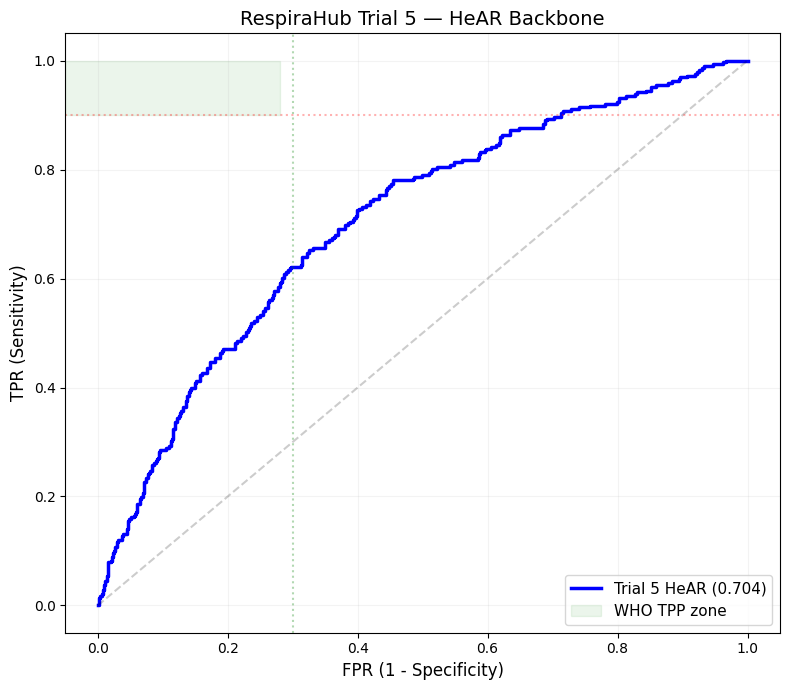

In [15]:
pids_order = sorted(all_patient_logits.keys())
y_true = np.array([all_patient_labels[p] for p in pids_order])
y_prob = np.array([all_patient_logits[p] for p in pids_order])

fpr_t5, tpr_t5, _ = roc_curve(y_true, y_prob)
auroc_t5 = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(8, 7))
plt.plot(fpr_t5, tpr_t5, 'b-', lw=2.5, label=f'Trial 5 HeAR ({auroc_t5:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.2)
plt.axhspan(0.90, 1.0, xmin=0, xmax=0.30, alpha=0.08, color='green', label='WHO TPP zone')
plt.axhline(0.90, color='r', ls=':', alpha=0.3)
plt.axvline(0.30, color='g', ls=':', alpha=0.3)
plt.xlabel('FPR (1 - Specificity)', fontsize=12)
plt.ylabel('TPR (Sensitivity)', fontsize=12)
plt.title('RespiraHub Trial 5 \u2014 HeAR Backbone', fontsize=14)
plt.legend(fontsize=11); plt.grid(alpha=0.15)
plt.tight_layout()
plt.savefig('roc_trial5.png', dpi=150)
plt.show()

In [16]:
print(f'{"Thresh":>7} {"Sens":>7} {"Spec":>7} {"PPV":>7} {"NPV":>7}')
print('-' * 40)

best_t, best_j = 0.5, -1
who_met = False

for t in np.arange(0.15, 0.85, 0.05):
    pred = (y_prob >= t).astype(int)
    tp = np.sum((pred == 1) & (y_true == 1))
    tn = np.sum((pred == 0) & (y_true == 0))
    fp = np.sum((pred == 1) & (y_true == 0))
    fn = np.sum((pred == 0) & (y_true == 1))
    sens = tp/(tp+fn) if (tp+fn) else 0
    spec = tn/(tn+fp) if (tn+fp) else 0
    ppv = tp/(tp+fp) if (tp+fp) else 0
    npv = tn/(tn+fn) if (tn+fn) else 0
    
    flag = ' \u2705 WHO' if (sens >= 0.90 and spec >= 0.70) else ''
    if sens >= 0.90 and spec >= 0.70: who_met = True
    
    j = sens + spec - 1
    if j > best_j: best_j, best_t = j, t
    
    print(f'{t:>7.2f} {sens:>7.3f} {spec:>7.3f} {ppv:>7.3f} {npv:>7.3f}{flag}')

print(f'\nBest Youden threshold: {best_t:.2f}')

 Thresh    Sens    Spec     PPV     NPV
----------------------------------------
   0.15   0.876   0.321   0.322   0.876
   0.20   0.808   0.453   0.352   0.865
   0.25   0.753   0.563   0.388   0.861
   0.30   0.656   0.664   0.418   0.840
   0.35   0.574   0.729   0.438   0.823
   0.40   0.471   0.805   0.471   0.805
   0.45   0.371   0.863   0.500   0.789
   0.50   0.265   0.910   0.520   0.771
   0.55   0.162   0.944   0.516   0.754
   0.60   0.107   0.973   0.596   0.748
   0.65   0.052   0.986   0.577   0.739
   0.70   0.034   0.991   0.588   0.736
   0.75   0.014   0.996   0.571   0.733
   0.80   0.003   0.997   0.333   0.731

Best Youden threshold: 0.30


---
## Cell 9: Save Everything

In [17]:
results_df = pd.DataFrame({
    'participant': pids_order,
    'true_label': y_true,
    'predicted_prob': y_prob,
})
results_df.to_csv('patient_predictions_trial5.csv', index=False)

summary = {
    'trial': 5,
    'backbone': 'HeAR (google/hear-pytorch)',
    'approach': 'Frozen HeAR embeddings + MLP classifier',
    'changes': [
        'Switch backbone from Wav2Vec2 to HeAR',
        '2s segments (HeAR native) instead of 3s',
        'Pre-extracted frozen embeddings (512-dim)',
        'Lightweight MLP head (~66K params)',
        '30 epochs with early stopping (patience 5)',
    ],
    'dataset': 'CODA TB solicited',
    'n_participants': len(pids_order),
    'n_segments': len(all_segments),
    'segment_sec': SEGMENT_SEC,
    'segments_per_patient_mean': round(float(np.mean(counts)), 1),
    'embedding_dim': int(all_embeddings.shape[1]),
    'n_folds': n_folds_actual,
    'auroc_mean': round(float(np.mean(fold_aurocs)), 4),
    'auroc_std': round(float(np.std(fold_aurocs)), 4),
    'auroc_per_fold': [round(float(a), 4) for a in fold_aurocs],
    'best_threshold': round(float(best_t), 2),
    'dream_winner': 0.743,
    'trial1_auroc': 0.7330,
    'device': str(DEVICE),
}
with open('training_summary_trial5.json', 'w') as f:
    json.dump(summary, f, indent=2)

print('Saved:')
print('  patient_predictions_trial5.csv')
print('  training_summary_trial5.json')
print('  hear_embeddings.pt')
print('  checkpoints_t5/hear_fold*.pt')
print('  roc_trial5.png')
print()
print('=' * 60)
print('TRIAL 5 COMPLETE — HeAR vs Wav2Vec2 Benchmark')
print('=' * 60)
print(f'Wav2Vec2 best (Trial 1): 0.7330 +/- 0.0565')
print(f'HeAR (Trial 5):          {np.mean(fold_aurocs):.4f} +/- {np.std(fold_aurocs):.4f}')
print(f'DREAM winner:            0.743')
print(f'\nDelta HeAR vs W2V: {np.mean(fold_aurocs) - 0.7330:+.4f}')
print(f'\nThis comparison is the foundation for the benchmark paper.')

Saved:
  patient_predictions_trial5.csv
  training_summary_trial5.json
  hear_embeddings.pt
  checkpoints_t5/hear_fold*.pt
  roc_trial5.png

TRIAL 5 COMPLETE — HeAR vs Wav2Vec2 Benchmark
Wav2Vec2 best (Trial 1): 0.7330 +/- 0.0565
HeAR (Trial 5):          0.7182 +/- 0.0614
DREAM winner:            0.743

Delta HeAR vs W2V: -0.0148

This comparison is the foundation for the benchmark paper.
